## Model Development

###Description

Data were acquired with three sensors (2 accelerometers - ADXL345/MMA8451Q and 1 gyroscope - ITG3200) at a frequency sample of 200 Hz



---


**Dataset fields:**

| Field | Description | Datatype |
| --- | --- | -- |
| ADXL345_X | X-axis acceleration data (ADXL345) | int |
| ADXL345_Y | Y-axis acceleration data (ADXL345) | int | 
| ADXL345_Z | Z-axis acceleration data (ADXL345) | int |
| ITG3200_X | X-axis rotation data (ITG3200) | int |
| ITG3200_Y | Y-axis rotation data (ITG3200) | int |
| ITG3200_Z | Z-axis rotation data (ITG3200) | int |
| MMA8451Q_X | X-axis acceleration data (MMA8451Q) | int |
| MMA8451Q_Y | Y-axis acceleration data (MMA8451Q) | int |
| MMA8451Q_Z | Z-axis acceleration data (MMA8451Q) | int |
| subject | Test participant code | string |
| trial | Test trial # | string |
| code | Activity code | string |
| code_ref | Activity code description | string |
| age | Test participant age | int |
| height | Test participant height | int |
| weight | Test participant weight | float |
| gender | Test participant sex | string |
| *class* | *Fall/No Fall (predictor label)* | *int* |

## Import Libraries

In [44]:
import glob
import os
import math
import time
import pandas as pd
import numpy as np
import itertools
import scipy as sp
import scipy.signal
from scipy.stats import randint
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_recall_curve, roc_curve, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ShuffleSplit, GroupShuffleSplit, learning_curve, cross_validate
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, RandomUnderSampler

In [45]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [46]:
import warnings
from sklearn.exceptions import FitFailedWarning as FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

## Download Dataset

In [4]:
# Install googleDriveFileDownloader
!pip install googleDriveFileDownloader

In [5]:
# Download SisFall dataset from google drive

from googleDriveFileDownloader import googleDriveFileDownloader
a = googleDriveFileDownloader()

a.downloadFile("https://drive.google.com/uc?id=1rJsYW0FMe_E9GQXxj4qZfyJjI2wStEOG&export=download")

Download is starting
SisFall_Processed.zip


1

In [6]:
# Unzip SisFall dataset from zip file
!unzip -oq SisFall_Processed.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Load Dataset

In [47]:
# Datatype Optimization Functions
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

def LoadSisFallDataset():
  df = pd.read_csv("feature_data.csv")
  df = optimize(df, [])
  df.info()

  return df

feature_ds = LoadSisFallDataset()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7145 entries, 0 to 7144
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   mn_accx   7145 non-null   float32 
 1   mn_accy   7145 non-null   float32 
 2   mn_accz   7145 non-null   float32 
 3   mn_gyrox  7145 non-null   float32 
 4   mn_gyroy  7145 non-null   float32 
 5   mn_gyroz  7145 non-null   float32 
 6   mn_accx2  7145 non-null   float32 
 7   mn_accy2  7145 non-null   float32 
 8   mn_accz2  7145 non-null   float32 
 9   subject   7145 non-null   category
 10  code      7145 non-null   category
 11  class     7145 non-null   int8    
dtypes: category(2), float32(9), int8(1)
memory usage: 275.3 KB


## Model Training

In [51]:
# Plots the precision-recall vs threshold curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=12) 
    plt.xlabel("Threshold", fontsize=12)        
    plt.grid(True)
    plt.title("Precision-Recall vs Threshold")
    #plt.show()                                           

# Plots the precision-recall curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    #plt.axis([-5, 10, 0, 1])
    plt.grid(True)
    plt.title("Precision-Recall")
    #plt.show()

# Plots the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)    
    plt.grid(True)
    plt.title("ROC")
    #plt.show()  

# Plots the learning curve
def plot_learning_curve(label, train_sizes, train_scores, validation_scores):  
    plt.xlabel("Training size")
    plt.ylabel(label)
    plt.plot(train_sizes, train_scores, 'o-', color="r",
             label="Training")
    plt.plot(train_sizes, validation_scores, 'o-', color="g",
             label="Validation")
    plt.legend(loc="best")      
    plt.title("Learning Curve")                                       

# Plots the confusion matrix
def plot_confusion_matrix(cm):
    sns.set_context('talk')
    ax = sns.heatmap(cm, annot=True, fmt='d')
    labels = ['NoFall', 'Fall']
    ax.set_xticklabels(labels);
    ax.set_yticklabels(labels);
    ax.set_ylabel('Actual');
    ax.set_xlabel('Predicted');

# Get evaluation metrics for trained model
def evalModel(model, X_train, y_train, X_val, y_val, showResults=True):
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  training_time = end_time - start_time

  y_val_pred = model.predict(X_val)
  val_accuracy = accuracy_score(y_val, y_val_pred )
  val_recall = recall_score(y_val, y_val_pred )
  val_logloss = log_loss(y_val, y_val_pred )

  if(showResults == True): 
    print('Validation accuracy = {:0.3f}'.format(val_accuracy))
    print('Validation recall = {:0.3f}'.format(val_recall))
    print('Validation log loss = {:0.3f}'.format(val_logloss))

  cm = confusion_matrix(y_val, y_val_pred)
  report = classification_report(y_val, y_val_pred, zero_division=0, output_dict=True)
  df_cr = pd.DataFrame(report).transpose()

  if hasattr(model, "decision_function"):
    y_scores = model.decision_function(X_val)
  else:
    y_scores = model.predict_proba(X_val)[:, 1]

  fpr, tpr, thresholds = roc_curve(y_val, y_scores)
  precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

  cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42) 
  train_sizes = np.geomspace(10, X_val.shape[0] , num=10, dtype=int)
  train_sizes, train_scores, validation_scores = learning_curve(
      model, X_train, y_train, cv=cv, scoring='accuracy', train_sizes=train_sizes, shuffle=True)
  train_errors_mean = 1. - np.mean(train_scores, axis=1)
  validation_errors_mean = 1. - np.mean(validation_scores, axis=1)

  if(showResults == True): 
    ##Li Wei - Start
    #fig=plt.figure(figsize=(20,4))
    fig=plt.figure(figsize=(25,5))
    ##Li Wei - End
    fig.add_subplot(1,5,1)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    fig.add_subplot(1,5,2)
    plot_precision_vs_recall(precisions, recalls)
    fig.add_subplot(1,5,3)
    plot_roc_curve(fpr, tpr)
    fig.add_subplot(1,5,4)
    plot_learning_curve('Error', train_sizes, train_errors_mean, validation_errors_mean)
    ##Li Wei - Start
    fig.add_subplot(1,5,5)
    plot_confusion_matrix(cm)
    ##Li Wei - End
    plt.show()

  return val_accuracy, val_recall, val_logloss, training_time, cm, df_cr        

# Get value means of list of dictionaries
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list if key != "name") / len(dict_list)
        mean_dict[key + "_vals"] = [d[key] for d in dict_list if key != "name"]
    return mean_dict

# Gets GroupShuffleSplit indices and train/test subsets for training/evaluation
def CVSplit(dataset, testUsers, numFeatures=9, num_splits=5, test_size=0.2, classLabel="class", grpLabel="subject"):
  # Get data subset excluding test users
  train_subset = dataset[~dataset["subject"].isin(testUsers)]
  # Get data subset of test users
  test_subset = dataset[dataset["subject"].isin(testUsers)]
  # Split data subset of test users into features and labels
  X_test, y_test = test_subset.iloc[:,:numFeatures], test_subset.iloc[:,-1]

  gss = GroupShuffleSplit(n_splits=num_splits, test_size=test_size, random_state=42)
  gss_splits = gss.split(train_subset, train_subset[classLabel], groups=train_subset[grpLabel])

  return gss_splits, train_subset, X_test, y_test

# Train/Evaluate models and get evaluation metrics
def trainModelsCV(models, dataset, testUsers, numFeatures=9, num_splits=5, test_size=0.2, showResults=False):
  ds_cv = []

  # Get GroupShuffleSplit indices and train/test data based on defined test users
  gss_splits, train_subset, X_test, y_test = CVSplit(dataset, 
                                                   testUsers=testUsers, 
                                                   numFeatures=numFeatures,
                                                   num_splits=num_splits, 
                                                   test_size=test_size)

  # Get list of train/validation datasets for each fold based on GroupShuffleSplit splits
  for train_index, val_index in gss_splits:
    grpshuffle_train_set = train_subset.iloc[train_index]
    grpshuffle_test_set = train_subset.iloc[val_index]
    X_train, y_train, X_val, y_val = grpshuffle_train_set.iloc[:,:numFeatures], grpshuffle_train_set.iloc[:,-1], grpshuffle_test_set.iloc[:,:numFeatures],  grpshuffle_test_set.iloc[:,-1]
    ds_cv.append((X_train, y_train, X_val, y_val))

  # List for storing model evaluation metrics
  modelMetrics_list = []

  # Evaluate all selected models
  for name, model in models.items():
    modelMetricsfold_list = []
    for ds in ds_cv:
      (X_train, y_train, X_val, y_val) = ds

      # Train/Evaluate model
      acc, recall, logloss, train_time, cm, cr = evalModel(model, X_train, y_train, X_val, y_val, showResults=showResults)
      
      # Validate on test data subset
      test_accuracy, test_recall = testModel(model, X_test, y_test, showResults=showResults)

      # Get TNs/FPs/FNs/TPs from confusion matrix
      tn, fp, fn, tp = cm.ravel()

      # Store evaluation metrics of fold in evalMetricsfold dictionary
      evalMetricsfold = {
        'name': name,
        'accuracy': round(acc, 3),
        'recall': round(recall, 3),
        'logloss': round(logloss, 3),
        'training time': round(train_time, 3),
        "true positive": tp,
        "false positive": fp,
        "true negative": tn,
        "false negative": fn,
        'precision_macro': round(cr.loc["macro avg"]["precision"], 3),
        'recall_macro': round(cr.loc["macro avg"]["recall"], 3),
        'f1_macro': round(cr.loc["macro avg"]["f1-score"], 3),
        'precision_0': round(cr.loc["0"]["precision"], 3),
        'precision_1': round(cr.loc["1"]["precision"], 3),
        'recall_0': round(cr.loc["0"]["recall"], 3),
        'recall_1': round(cr.loc["1"]["recall"], 3),
        'test_accuracy': test_accuracy,
        'test_recall': test_recall  
      }
      # Add evalMetricsfold dictionary to modelMetricsfold_list list
      modelMetricsfold_list.append(evalMetricsfold)

    # Calculate mean of evaluation metrics for all folds (per metric)
    modelMetricsfoldCV = dict_mean(modelMetricsfold_list)
    modelMetricsfoldCV["name"] = name

    # Add modelMetricsfoldCV dictionary to modelMetricsfold_list list
    modelMetrics_list.append(modelMetricsfoldCV)

  # Convert modelMetrics_list to Pandas dataframe
  modelMetrics_df = pd.DataFrame.from_dict(modelMetrics_list)

  return modelMetrics_df

# Get evaluation metrics of trained model for test subset 
def testModel(model, X_test, y_test, showResults=True):
  y_test_pred = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_test_pred )
  test_recall = recall_score(y_test, y_test_pred )

  if(showResults == True):
    print('Test accuracy = {:0.3f}'.format(test_accuracy))
    print('Test recall = {:0.3f}'.format(test_recall))
    
#   ##Li Wei 
#   fig, ax = plt.subplots()
#   ax.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
#   ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
#   ax.set_xlabel('Measured')
#   ax.set_ylabel('Predicted')
#   plt.show()

  #print(confusion_matrix(y_test, y_test_pred))
  #print(classification_report(y_test, y_test_pred, zero_division=0))
  return test_accuracy, test_recall

# Perform model hyperparameter tuning (Random/Grid)
def tuneModel(model, params, dataset, testUsers, numFeatures=9, num_splits=5, test_size=0.2, tune_algo="Random"):

  # Get GroupShuffleSplit indices and train/test data based on defined test users
  gss_splits, _, X_test, y_test = CVSplit(dataset, 
                                          testUsers=testUsers, 
                                          numFeatures=numFeatures,
                                          num_splits=num_splits, 
                                          test_size=test_size)
  
  # Get data subset excluding test users
  ds = feature_ds[~feature_ds["subject"].isin(testUsers)]

  # Instantiate the RandomizedSearchCV object
  if(tune_algo == "Random"):
    grid_cv = RandomizedSearchCV(model, params, cv=list(gss_splits))
  elif(tune_algo == "Grid"):
    grid_cv = GridSearchCV(model, params, cv=list(gss_splits))

  # Fit it to the data
  grid_cv.fit(ds.iloc[:,:numFeatures], ds.iloc[:,-1])

  # Print the tuned parameters and score
  print("Tuned Parameters: {}".format(grid_cv.best_params_))
  print("Best score is {}".format(grid_cv.best_score_))

  return grid_cv

# Highlights best values for each evaluation metric in yellow
def formatSummary(df):
  # Columns used for evaluating maximum
  cols_max =	['accuracy', 'recall', 'true positive', 'true negative', 'precision_macro', 'recall_macro',
              'f1_macro',	'precision_0',	'precision_1',	'recall_0',	'recall_1', 'test_accuracy',
              'test_recall']
  # Columns used for evaluating minimum
  cols_min = ['logloss', 'training time', 'false positive', 'false negative'] 

  # Exclude "_vals" columns storing individual fold metrics 
  df_mean = df.loc[:,~df.columns.str.endswith('_vals')]
  # Format modelMetrics_df_display for maximum/minimum highlight
  df_mean = df_mean.style.highlight_max(subset = cols_max, color = 'yellow').highlight_min(subset = cols_min, color = 'yellow').set_precision(3)

  return df_mean

# Plots the model feature importances
def plotFeatureImportances(model, feature_cols):
  feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
  fig = plt.figure(figsize=(12,5))
  ax = feature_imp.plot(kind='bar')
  ax.set(ylabel='Relative Importance');

## Model Evaluation

In [52]:
# Setup ensemble models for evaluation
models_ensemble = {"Random Forest": RandomForestClassifier(n_estimators=25, random_state=42),
                    "Extra Trees": ExtraTreesClassifier(n_estimators=25, random_state=42),
                    "AdaBoost": AdaBoostClassifier(random_state=42),
                    "Gradient Boosted Tree": GradientBoostingClassifier(random_state=42)
}

# Setup simple models for evaluation
models_simple = {"Logistic Regression": LogisticRegression(solver="liblinear", max_iter=300 ,random_state=42),
                  "Decision Tree": DecisionTreeClassifier(random_state=42),
                  "K-Nearest Neighbours": KNeighborsClassifier(3),
                  "Naive Bayes": GaussianNB(),
                  #"LinearSVC": SVC(kernel="linear", random_state=42)
}

# Setup mixed simple/ensemble models for evaluation
models_all = {**models_simple, **models_ensemble} 

# Setup test users
testUsers = ["SE06", "SE15"]
##testUsers = ["SA01", "SA02"]
             ##, "SA03", "SA04", "SA05", "SA06", "SA07", "SA08", "SA09", "SA10", "SA11", "SA12", "SA13", "SA14", "SA15", "SA16", "SA17", "SA18", "SA19", "SA20", "SA21", "SA22", "SA23"]            


In [53]:
# Train on basic models
summary_CV_basic = trainModelsCV(models = models_simple, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.851,0.742,5.154,0.048,436.200,84.400,903.600,151.000,0.846,0.829,0.835,0.859,0.833,0.915,0.742,0.787,0.623
1,Decision Tree,0.905,0.883,3.286,0.105,518.800,80.800,907.200,68.400,0.896,0.900,0.897,0.930,0.861,0.918,0.883,0.849,0.739
2,K-Nearest Neighbours,0.940,0.907,2.066,0.022,534.400,41.200,946.800,52.800,0.937,0.933,0.935,0.947,0.928,0.958,0.907,0.866,0.735
3,Naive Bayes,0.872,0.850,4.405,0.003,499.800,113.800,874.200,87.400,0.860,0.868,0.864,0.909,0.811,0.885,0.850,0.839,0.790


Tuning

Inverse of regularization strength, C : 1.0, 5.0, 10.0

In [54]:
# Setup simple models for evaluation
models_simple = {"Logistic Regression": LogisticRegression(solver="liblinear", max_iter=300 ,random_state=42) }

# Train on basic models - logistic regression only
summary_CV_basic = trainModelsCV(models = models_simple, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.851,0.742,5.154,0.048,436.200,84.400,903.600,151.000,0.846,0.829,0.835,0.859,0.833,0.915,0.742,0.787,0.623


In [18]:
models_simple1 = {"Logistic Regression": LogisticRegression(penalty='l2', C=5.0, solver="liblinear", max_iter=300 ,random_state=42) }

# Train on basic models - logistic regression only
summary_CV_basic = trainModelsCV(models = models_simple1, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.852,0.727,5.116,0.047,425.400,74.400,923.400,161.800,0.850,0.826,0.834,0.853,0.847,0.925,0.727,0.795,0.619


In [55]:
models_simple2 = {"Logistic Regression": LogisticRegression(penalty='l2', C=10.0, solver="liblinear", max_iter=300 ,random_state=42) }

# Train on basic models - logistic regression only
summary_CV_basic = trainModelsCV(models = models_simple2, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.852,0.747,5.132,0.048,438.800,86.000,902.000,148.400,0.846,0.830,0.836,0.861,0.831,0.913,0.747,0.786,0.627


In [8]:
models_simple2 = {"Logistic Regression": LogisticRegression(penalty='l2', C=10.0, fit_intercept=False, solver="liblinear", max_iter=300 ,random_state=42) }

# Train on basic models - logistic regression only
summary_CV_basic = trainModelsCV(models = models_simple2, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

# Conclusion:
# fit_intercept=False affects the recall drastically from 70% down to 30% and more than 10% drop in accuracy !

,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.722,0.307,9.613,0.020,183.000,39.600,958.200,404.200,0.757,0.634,0.626,0.706,0.809,0.960,0.307,0.636,0.227


Validation accuracy = 0.876
Validation recall = 0.798
Validation log loss = 4.283


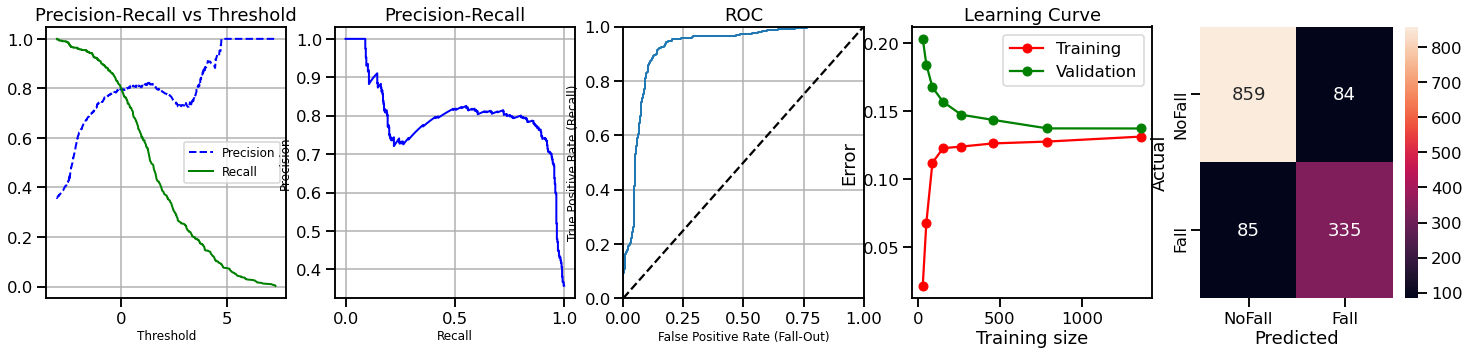

Test accuracy = 0.795
Test recall = 0.705
Validation accuracy = 0.866
Validation recall = 0.790
Validation log loss = 4.626


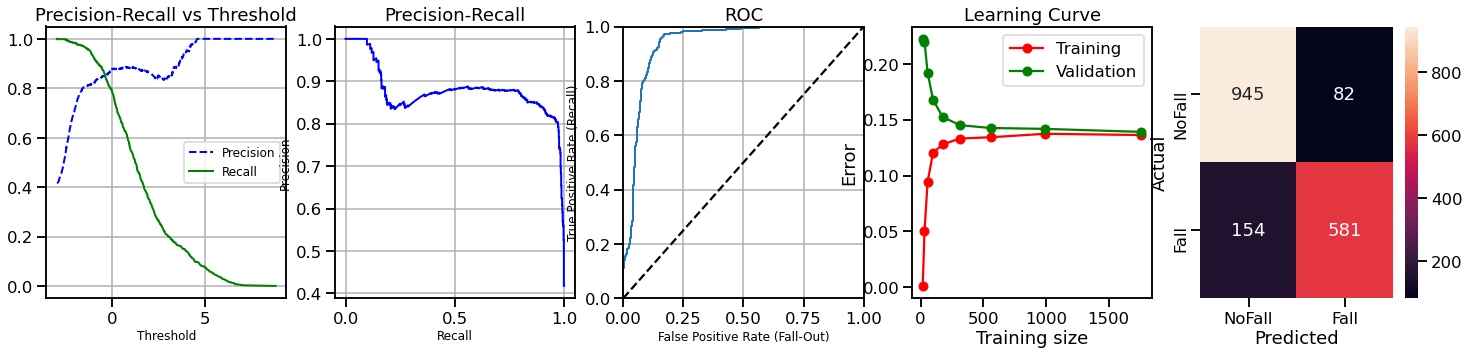

Test accuracy = 0.789
Test recall = 0.610
Validation accuracy = 0.825
Validation recall = 0.674
Validation log loss = 6.033


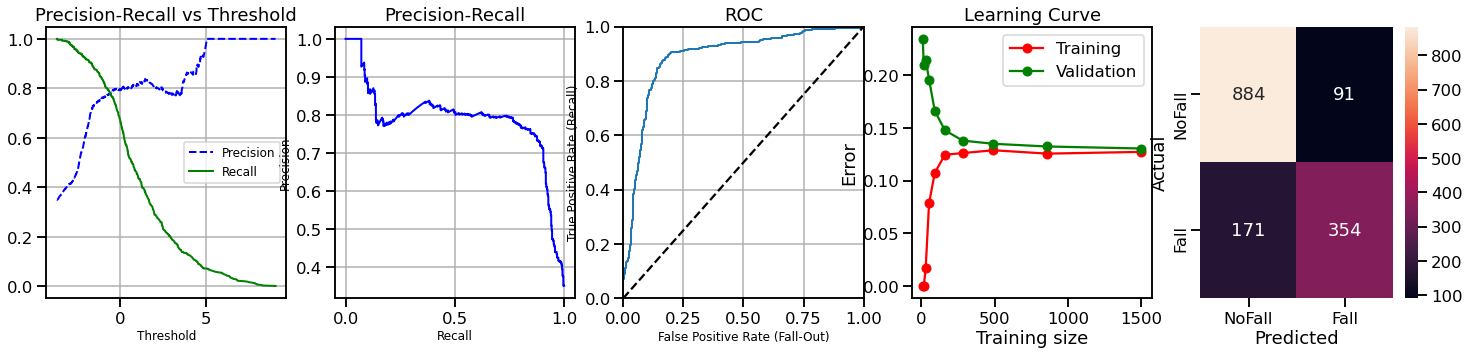

Test accuracy = 0.763
Test recall = 0.533
Validation accuracy = 0.875
Validation recall = 0.821
Validation log loss = 4.323


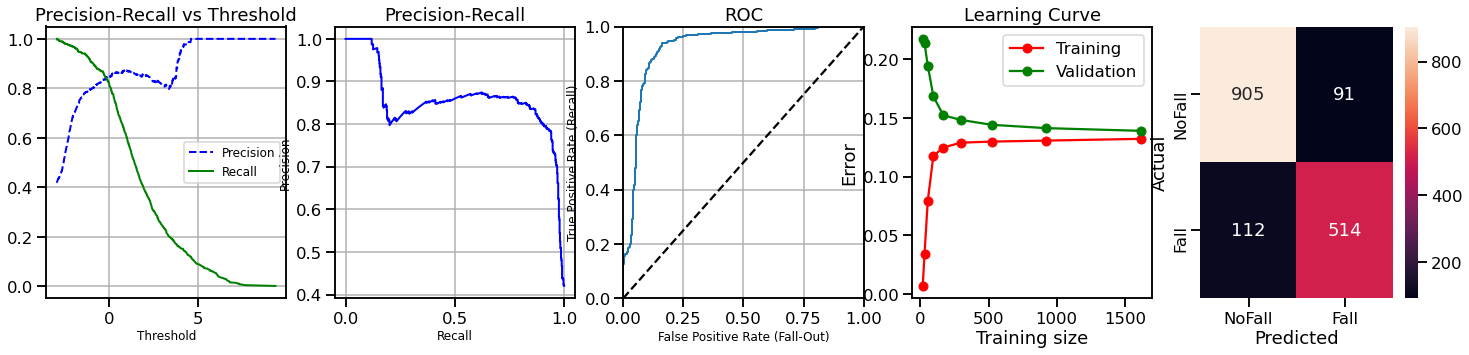

Test accuracy = 0.789
Test recall = 0.657
Validation accuracy = 0.832
Validation recall = 0.697
Validation log loss = 5.810


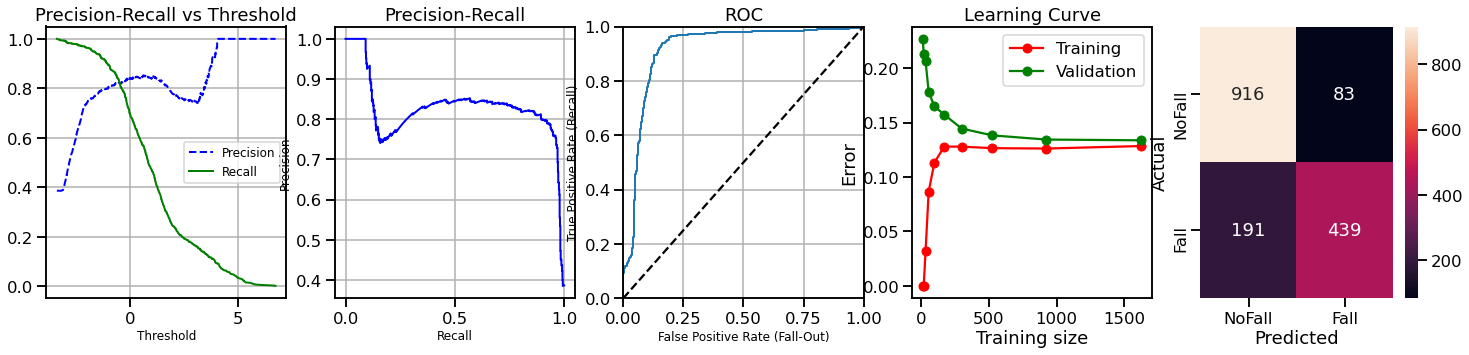

Test accuracy = 0.801
Test recall = 0.676


,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.855,0.756,5.015,0.190,444.600,86.200,901.800,142.600,0.849,0.834,0.840,0.865,0.833,0.913,0.756,0.787,0.636


In [32]:
# Trying a different solver than "liblinear"
# Try: "lbfgs" 
# Need to increase: max_iter=300 to 600 to 1000

models_simple2 = {"Logistic Regression": LogisticRegression(penalty='l2', C=1, fit_intercept=True, solver="lbfgs", max_iter=1000 ,random_state=42) }

# Train on basic models - logistic regression only
summary_CV_basic = trainModelsCV(models = models_simple2, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

In [ ]:
#

models_simple2 = {"Logistic Regression": LogisticRegression(penalty='elasticnet', C=0.5, fit_intercept=True, 
                                                            solver="saga", l1_ratio=0.5, max_iter=5000 ,random_state=42) }

# Train on basic models - logistic regression only
summary_CV_basic = trainModelsCV(models = models_simple2, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_basic)

In [12]:
summary_CV_basic

,name,name_vals,accuracy,accuracy_vals,recall,recall_vals,logloss,logloss_vals,training time,training time_vals,...,precision_1,precision_1_vals,recall_0,recall_0_vals,recall_1,recall_1_vals,test_accuracy,test_accuracy_vals,test_recall,test_recall_vals
0,Logistic Regression,[],0.8538,"[0.85, 0.881, 0.875, 0.849, 0.814]",0.7326,"[0.695, 0.806, 0.779, 0.737, 0.646]",5.051,"[5.172, 4.096, 4.329, 5.223, 6.435]",0.2776,"[0.658, 0.202, 0.169, 0.151, 0.208]",...,0.847,"[0.785, 0.871, 0.85, 0.855, 0.874]",0.9248,"[0.917, 0.927, 0.926, 0.92, 0.934]",0.7326,"[0.695, 0.806, 0.779, 0.737, 0.646]",0.793671,"[0.8080168776371308, 0.8122362869198312, 0.780...",0.619048,"[0.6428571428571429, 0.6714285714285714, 0.585..."


In [ ]:
feature_ds

In [12]:
# Train on ensemble models
summary_CV_ensemble = trainModelsCV(models = models_ensemble, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_ensemble)

,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Random Forest,0.943,0.917,1.967,0.427,539.600,42.600,955.200,47.600,0.939,0.938,0.938,0.953,0.925,0.958,0.917,0.905,0.853
1,Extra Trees,0.948,0.927,1.787,0.135,544.600,39.400,958.400,42.600,0.944,0.944,0.944,0.958,0.931,0.961,0.927,0.910,0.853
2,AdaBoost,0.908,0.869,3.173,0.502,511.000,69.800,928.000,76.200,0.901,0.900,0.900,0.924,0.878,0.930,0.869,0.886,0.838
3,Gradient Boosted Tree,0.932,0.901,2.359,1.697,529.000,50.200,947.600,58.200,0.927,0.925,0.926,0.943,0.911,0.950,0.901,0.894,0.840


In [ ]:
# Train on all models
summary_CV_all = trainModelsCV(models = models_all, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 5,
                           test_size=0.2)

formatSummary(summary_CV_all)

## Hyperparameter Tuning

In [ ]:
# Show default parameters of selected model
models_all['Extra Trees']

In [ ]:
# Define tuning parameters
param_grid = {'n_estimators': [25, 100, 250],
              'max_depth': [5, 15, 50],
              'max_features': ['auto', 'sqrt', 'log2']}

# Set tune_algo = "Grid" for GridSearch, "Random" for RandomizedSearch
model_grid = tuneModel(model = models_all['Extra Trees'], 
                       params = param_grid, 
                       dataset = feature_ds, 
                       testUsers = testUsers,
                       numFeatures=9, 
                       num_splits=5, 
                       test_size=0.2, 
                       tune_algo = "Grid")

In [ ]:
# Check tuned model performance
model = {"Tuned Extra Trees": model_grid.best_estimator_}

summary_best = trainModelsCV(models = model, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 1,
                           test_size=0.2,
                           showResults=True)

formatSummary(summary_best)

In [ ]:
def plotGridSearchResults(search_results, param_x, param_y, param_hue):
  cv_results = pd.DataFrame(search_results)
  col_x = 'param_' + param_x
  col_hue = 'param_' + param_hue
  splot = sns.barplot(x=col_x, y=param_y, hue=col_hue, data=cv_results, ci=None);
  plt.title("")
  plt.xlabel(param_x)
  plt.ylabel(param_y)
  plt.ylim(0.924, 0.926)
  #ax.legend(title=param_hue)
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points')

plotGridSearchResults(model_grid.cv_results_, "max_features", "mean_test_score", "n_estimators")


In [ ]:
# Check tuned model feature importances
feature_cols = [x for x in feature_ds.columns if x not in ['class', 'subject', 'code']]

plotFeatureImportances(best_model, feature_cols)

Tuning for Logistic Regression

In [62]:
# Show default parameters of selected model
models_all['Logistic Regression']


LogisticRegression(max_iter=300, random_state=42, solver='liblinear')

In [69]:
# Define tuning parameters
# param_grid = {'C': [1, 0.5, 0.2],
#               'solver': ['liblinear', 'lbfgs'],
#               'max_iter': [100, 250, 500, 750, 1000, 2500, 5000, 10000, 25000]}

param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
              'C': [1, 0.5, 0.2],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 250, 500, 750, 1000, 2500, 5000]}

# Set tune_algo = "Grid" for GridSearch, "Random" for RandomizedSearch
model_grid = tuneModel(model = models_all['Logistic Regression'], 
                       params = param_grid, 
                       dataset = feature_ds, 
                       testUsers = testUsers,
                       numFeatures=9, 
                       num_splits=5, 
                       test_size=0.2, 
                       tune_algo = "Grid")

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorit

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty=

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.",

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio param

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio param

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio param

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-pa

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty=

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setti

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty=

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty=

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty=

D:\2020\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\li

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio param

D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
D:\2020\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio param

Tuned Parameters: {'C': 0.5, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score is 0.8564432486520739


D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

Validation accuracy = 0.876
Validation recall = 0.798
Validation log loss = 4.283


D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\2020\an

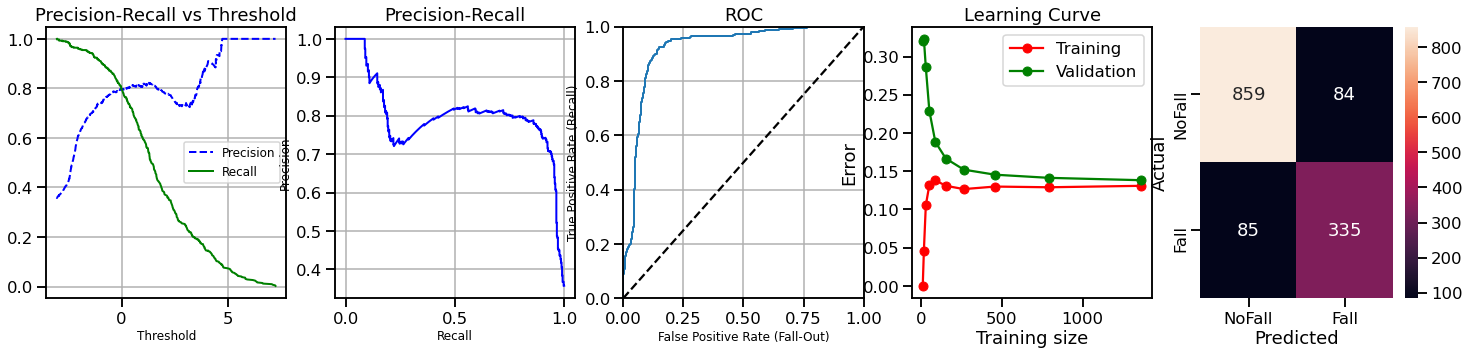

Test accuracy = 0.798
Test recall = 0.705


,name,accuracy,recall,logloss,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1,test_accuracy,test_recall
0,Logistic Regression,0.876,0.798,4.283,0.319,335.000,84.000,859.000,85.000,0.855,0.854,0.855,0.910,0.800,0.911,0.798,0.798,0.705


In [71]:
# Check tuned model performance
model = {"Logistic Regression": model_grid.best_estimator_}

summary_best = trainModelsCV(models = model, 
                           dataset = feature_ds,
                           testUsers = testUsers, 
                           numFeatures = 9,
                           num_splits = 1,
                           test_size=0.2,
                           showResults=True)

formatSummary(summary_best)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression

In [ ]:
def plotGridSearchResults(search_results, param_x, param_y, param_hue):
  cv_results = pd.DataFrame(search_results)
  col_x = 'param_' + param_x
  col_hue = 'param_' + param_hue
  splot = sns.barplot(x=col_x, y=param_y, hue=col_hue, data=cv_results, ci=None);
  plt.title("")
  plt.xlabel(param_x)
  plt.ylabel(param_y)
  plt.ylim(0.924, 0.926)
  #ax.legend(title=param_hue)
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points')

plotGridSearchResults(model_grid.cv_results_, "max_features", "mean_test_score", "n_estimators")

In [ ]:
# Check tuned model feature importances
feature_cols = [x for x in feature_ds.columns if x not in ['class', 'subject', 'code']]

plotFeatureImportances(best_model, feature_cols)